# Hiperparametros, optimización y overfit

In [3]:
import pandas as pd

datos = pd.read_csv("carros.csv")
datos.head()

,precio,vendido,edad_del_modelo,km_by_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [4]:
#situacion con los datos ordenados de la peor manera
datos_ord = datos.sort_values("vendido", ascending=True)
x_ord = datos_ord[["precio", "edad_del_modelo","km_by_year"]]
y_ord = datos_ord["vendido"]
datos_ord.head()

,precio,vendido,edad_del_modelo,km_by_year
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [7]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

Accuracy con dummy stratified, 10 = [58.00, 58.00]


In [6]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

Accuracy con cross validation, 10 = [73.83, 77.73]


In [8]:
#generando datos aleatorios del modelo de carro
np.random.seed(SEED)
datos['modelo'] = datos.edad_del_modelo + np.random.randint(-2, 3, size=10000)
datos.modelo = datos.modelo + abs(datos.modelo.min()) + 1
datos.head()

,precio,vendido,edad_del_modelo,km_by_year,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


Vamos a utilizar este nueva columna 'modelo' para ver si mejoramos en algo la precisión del modelo.

In [9]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desviacion = results['test_score'].std() * 100
  print("Accuracy media %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desviacion, media + 2 * desviacion))

In [12]:
# GroupKFold en un pipeline con StandardScaler y SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacion',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 76.68
Intervalo [74.28, 79.08]


In [16]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10) #Divide en 10, o sea 10 modelos
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False) # groups es la agrupacion, que va utilizar la 
#nueva columna para ver si mejora la precisión
imprime_resultados(results)

Accuracy media 75.78
Intervalo [73.67, 77.90]


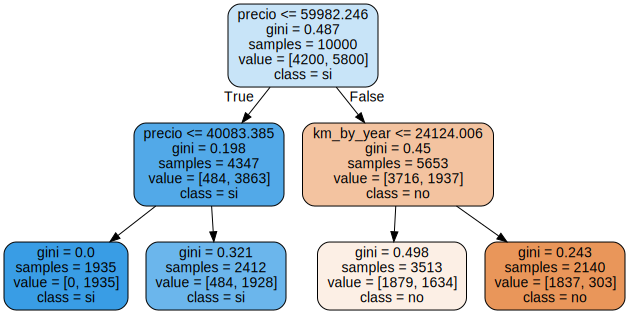

In [17]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_ord,y_ord)
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['no','si'],feature_names=features)
#out_file=None: es para que no se exporte a ningun archivo
#filled=True: es para que las cajitas esten rellenas
#rounded=True: es para los bordes
graph = graphviz.Source(dot_data)
graph

In [18]:
#Cambio la profundidad
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 78.67
Intervalo [76.40, 80.94]


Cambiando la profundidad, la precisión mejora en este caso.

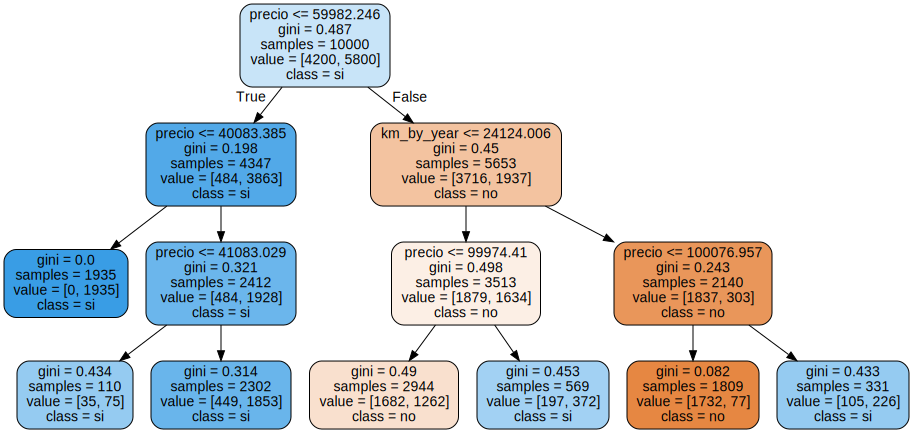

In [19]:
modelo.fit(x_ord,y_ord)
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, class_names=['no','si'],feature_names=features)

graph = graphviz.Source(dot_data)
graph

In [20]:
#Cambio la profundidad a 10
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy media 77.19
Intervalo [75.26, 79.13]


Como conclusión se puede decir que no porque se aumente la profundidad va a mejorar la precisión del modelo también.

Los parametros que se colocan antes de entrenar un modelo se llaman hiperparametros. Durante el modelo se generan parametros internos del modelo que realizan calculos especificos de acuerdo a los hiperparametros, estos valores no son hiperparametros, estos son parametros.

¿Como sabemos cual es el mejor valor de profundidad para el modelo?

In [24]:
def iniciar_arbol_de_decision(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
  test_score = results['test_score'].mean()*100
  train_score = results['train_score'].mean()*100
  print('Arbol max_depth = %d, training = %.2f, testing = %.2f' %(max_depth, train_score, test_score))
  tabla = [max_depth, train_score, test_score]
  return tabla

resultados = [iniciar_arbol_de_decision(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns=['max_depth','train', 'test'])
resultados.head()

Arbol max_depth = 1, training = 75.79, testing = 75.78
Arbol max_depth = 2, training = 75.79, testing = 75.78
Arbol max_depth = 3, training = 78.75, testing = 78.67
Arbol max_depth = 4, training = 78.79, testing = 78.63
Arbol max_depth = 5, training = 78.94, testing = 78.56
Arbol max_depth = 6, training = 79.17, testing = 78.12
Arbol max_depth = 7, training = 79.50, testing = 77.96
Arbol max_depth = 8, training = 79.89, testing = 77.86
Arbol max_depth = 9, training = 80.46, testing = 77.38
Arbol max_depth = 10, training = 81.16, testing = 77.19
Arbol max_depth = 11, training = 82.03, testing = 76.97
Arbol max_depth = 12, training = 82.89, testing = 76.49
Arbol max_depth = 13, training = 83.95, testing = 75.81
Arbol max_depth = 14, training = 85.03, testing = 75.66
Arbol max_depth = 15, training = 86.14, testing = 75.16
Arbol max_depth = 16, training = 87.19, testing = 75.11
Arbol max_depth = 17, training = 88.31, testing = 74.74
Arbol max_depth = 18, training = 89.26, testing = 74.33
A

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


Viendo los prints se puede ver que estamos enfrentando un problema de overfit. Para ver mejor el problema lo podemos ver con una gráfica.

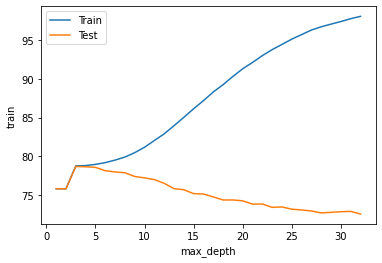

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x='max_depth',y='train', data=resultados);
sns.lineplot(x='max_depth',y='test', data=resultados);
plt.legend(['Train','Test'])

In [30]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


La profundidad de un árbol va a ser mejor para los datos de entrenamiento pero si no es mejor para los datos de prueba(dato real) entonces estamos viendo un overfitting.